# MSM of EF-hand
Build an MSM on the EF-hand domain of cTnC and the catalytic Ca<sup>2+</sup> atom.

In [1]:
from msmbuilder.dataset import dataset
import mdtraj as md
import numpy as np
from glob import glob
from mdtraj.utils import timing
import itertools
from msmbuilder.featurizer import AtomPairsFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMeans

In [2]:
traj_list = sorted(glob("/Users/je714/wt_data/*/05*nc"))

In [3]:
top = md.load_prmtop("/Users/je714/wt_data/run1/WT-ff14SB_clean.prmtop")

In [4]:
ef_hand = top.select("resid 64 to 74")
cat_cal = top.select("resid 419")

In [5]:
atom_sel = np.append(ef_hand, cat_cal)

In [6]:
atom_sel

array([ 996,  997,  998,  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006,
       1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017,
       1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028,
       1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039,
       1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050,
       1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061,
       1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072,
       1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083,
       1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094,
       1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105,
       1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116,
       1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127,
       1128, 1129, 1130, 1131, 1132, 1133, 6809])

In [7]:
xyz = dataset("/Users/je714/wt_data/*/05*nc", fmt='mdtraj', 
               topology="/Users/je714/wt_data/run1/WT-ff14SB_clean.prmtop",
               atom_indices=atom_sel)

We featurize the trajectories into the pairwise distance between all the atoms in the EF hand and the catalytic Ca<sup>2+</sup>. Since we only loaded the relevant atoms, msmbuilder renumbers the indices from 0.

In [50]:
pairs = np.asarray(list(itertools.product(list(range(139)), [138])))

In [51]:
print(pairs.shape)

(139, 2)


In [11]:
pairs_noIJ = pairs[pairs[:,0] != pairs[:,1]] # Drop out the elements that are i=j (the distance will be 0)

In [12]:
pairs_noIJ

array([[  0, 138],
       [  1, 138],
       [  2, 138],
       [  3, 138],
       [  4, 138],
       [  5, 138],
       [  6, 138],
       [  7, 138],
       [  8, 138],
       [  9, 138],
       [ 10, 138],
       [ 11, 138],
       [ 12, 138],
       [ 13, 138],
       [ 14, 138],
       [ 15, 138],
       [ 16, 138],
       [ 17, 138],
       [ 18, 138],
       [ 19, 138],
       [ 20, 138],
       [ 21, 138],
       [ 22, 138],
       [ 23, 138],
       [ 24, 138],
       [ 25, 138],
       [ 26, 138],
       [ 27, 138],
       [ 28, 138],
       [ 29, 138],
       [ 30, 138],
       [ 31, 138],
       [ 32, 138],
       [ 33, 138],
       [ 34, 138],
       [ 35, 138],
       [ 36, 138],
       [ 37, 138],
       [ 38, 138],
       [ 39, 138],
       [ 40, 138],
       [ 41, 138],
       [ 42, 138],
       [ 43, 138],
       [ 44, 138],
       [ 45, 138],
       [ 46, 138],
       [ 47, 138],
       [ 48, 138],
       [ 49, 138],
       [ 50, 138],
       [ 51, 138],
       [ 52,

In [52]:
traj1 = xyz[0]

In [14]:
dist_featurizer = AtomPairsFeaturizer(pair_indices=pairs)

In [15]:
with timing("Featurizing into distances..."):
    dists = dist_featurizer.fit_transform(xyz)

Featurizing into distances...: 2507.774 seconds


In [95]:
tica_model = tICA(n_components=10, lag_time=1)
with timing("tica..."):
    tica_trajs_dists = tica_model.fit_transform(dists)

tica...: 1.403 seconds


In [96]:
tica_model = tICA

In [97]:
tica_trajs_dists[0].shape

(2500, 10)

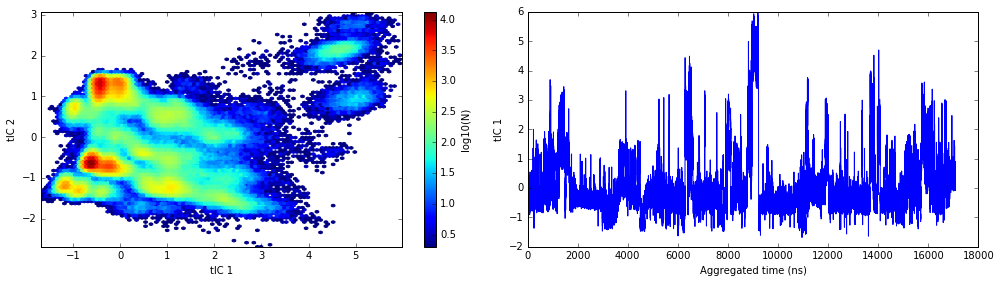

In [98]:
%matplotlib inline
from matplotlib import pyplot as plt
txx = np.concatenate(tica_trajs_dists)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
cb = plt.colorbar()
cb.set_label('log10(N)')

plt.subplot(1,2,2)
time = np.linspace(start=0.0, stop=txx.shape[0]*0.02, num = txx.shape[0])
plt.plot(time, txx[:,0])
plt.xlabel("Aggregated time (ns)")
plt.ylabel("tIC 1")

plt.tight_layout()

In [103]:
clusterer = MiniBatchKMeans(n_clusters=400)
with timing("Clustering tica trajs from dist featurization..."):
    clustered_trajs = clusterer.fit_transform(tica_trajs_dists)

/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Clustering tica trajs from dist featurization...: 29.141 seconds


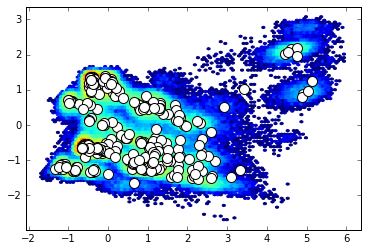

In [104]:
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1)
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [105]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2)
msm.fit(clustered_trajs)
print("The MSM has %s states.\n" % msm.n_states_)
print(msm.left_eigenvectors_.shape)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%
The MSM has 400 states.

(400, 400)


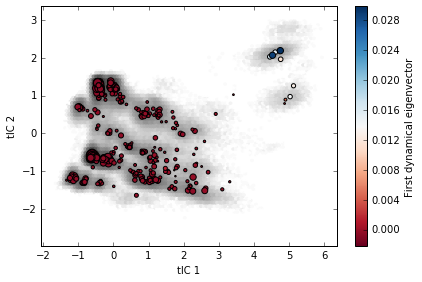

In [106]:
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap="Greys")
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1],
            s=1e4 * msm.populations_, # size by population
            c=msm.left_eigenvectors_[:,1], # color by eigenvector
            cmap="RdBu") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [107]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=5)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -4.967211
         Iterations: 39
         Function evaluations: 230


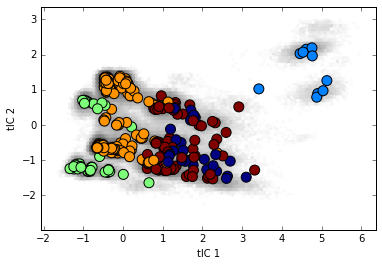

In [108]:
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap="Greys")
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1],
            s=100,
            c=pcca.microstate_mapping_,
      )
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')

# Cross validation

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats.distributions import randint

In [90]:
model = Pipeline([
    ('featurizer', AtomPairsFeaturizer(pair_indices=pairs)),
    ('tica', tICA(n_components=4)),
    ('clusterer', MiniBatchKMeans()),
    ('msm', MarkovStateModel(n_timescales=3, ergodic_cutoff='on', reversible_type='mle', verbose=False))
])
search = RandomizedSearchCV(model, n_iter=50, cv=3, refit=False, param_distributions={
        'tica__lag_time':randint(1,100),    
        'clusterer__n_clusters':randint(1,1000),
        'msm__lag_time':randint(1,100)
})

In [109]:
def plot_scores(score_matrix):
    from matplotlib import pyplot as pp
    scores = np.array([[np.mean(e.cv_validation_scores),
                        np.std(e.cv_validation_scores),
                        e.parameters['tica__lag_time'],
                        e.parameters['clusterer__n_clusters'],
                        e.parameters['msm__lag_time']]
                        for e in score_matrix.grid_scores_])

    mean_score_value = scores[:,0]
    std_score_value = scores[:,1]
    lags_tica = scores[:,2]
    cluster_number = scores[:,3]
    lags_msm = scores[:,4]

    pp.figure(figsize=(14,4))
    pp.grid(False)
    interval = 2*std_score_value
    # subplot1
    pp.subplot(1,3,1, axisbg='white')
    pp.errorbar(x=lags_tica, y=mean_score_value, yerr=interval, color = 'b', fmt='o')
    pp.plot(pp.xlim(), [search.best_score_]*2, 'k-.', label = 'best')
    pp.xlabel("tICA lag time (Frame)")
    pp.ylabel("Score")
    # subplot2
    pp.subplot(1,3,2, axisbg='white')
    pp.errorbar(x=cluster_number, y=mean_score_value, yerr=interval,  color = 'r', fmt='o')
    pp.plot(pp.xlim(), [search.best_score_]*2, 'k-.', label = 'best')
    pp.xlabel("Number of clusters")
    pp.ylabel("Score")
    # subplot3
    pp.subplot(1,3,3, axisbg='white')
    pp.errorbar(x=lags_msm, y=mean_score_value, yerr=interval, color = 'g', fmt='o')
    pp.plot(pp.xlim(), [search.best_score_]*2, 'k-.', label = 'best')
    pp.xlabel("MSM lag time (Frame)")
    pp.ylabel("Score")

    pp.tight_layout()

In [92]:
with timing("Cross validation..."):
    xyz_scores = search.fit(xyz)
for key, value in xyz_scores.best_params_.items():
    print("%s\t%s" % (key, value))
print("Score = %.2f" % xyz_scores.best_score_)


/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=783. Setting it to 3*k
  init_size=init_size)
/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=783. Setting it to 3*k
  init_size=init_size)
/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=783. Setting it to 3*k
  init_size=init_size)
/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=523. Setting it to 3*k
  init_size=init_size)
/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=523. Setting it to 3*k
  init_size=init_size)
/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_

Cross validation...: 6180.014 seconds
clusterer__n_clusters	445
msm__lag_time	2
tica__lag_time	1
Score = 3.75


NameError: name 'pp' is not defined

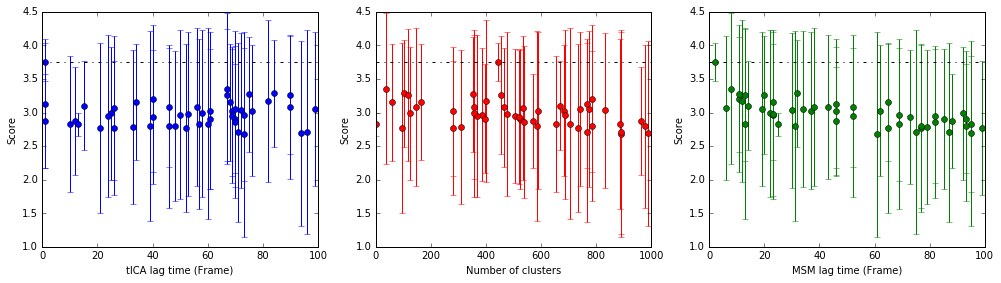

In [110]:
plot_scores(xyz_scores)

In [111]:
model = Pipeline([
    ('tica', tICA(n_components=4)),
    ('clusterer', MiniBatchKMeans()),
    ('msm', MarkovStateModel(n_timescales=3, ergodic_cutoff='on', reversible_type='mle', verbose=False))
])
search = RandomizedSearchCV(model, n_iter=100, cv=3, refit=False, param_distributions={
        'tica__lag_time':randint(1,100),    
        'clusterer__n_clusters':randint(1,1000),
        'msm__lag_time':randint(1,100)
})

In [ ]:
with timing("Cross validation on trajectories already fit to distance feature..."):
    feat_scores = search.fit(dists)

/Users/je714/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=900. Setting it to 3*k
  init_size=init_size)
